# Jan 6, 2025: dominant/important communities
which communities appear in most of the modes?

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats, linalg
from scipy.spatial.distance import jensenshannon, cosine
from multiprocessing import Pool
import glob
import random

from sklearn.cluster import DBSCAN, SpectralCoclustering, SpectralClustering
from scipy.optimize import linear_sum_assignment

import arviz as az

import ants
from nipype.interfaces import afni

from itertools import product, combinations, chain
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [ ]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results_v2/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
RSN_ROI_path = f'{ROI_path}/rsns'
os.system(f'mkdir -p {RSN_ROI_path}')
IC_ROI_path = f'{ROI_path}/ics'
os.system(f'mkdir -p {IC_ROI_path}')
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
args.dc, args.sbm = False, 'h'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['m', 'a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [6]:
marginals_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl', recursive=True))
marginals_df = []
for sbm_file in marginals_files:
    with open(f'{sbm_file}', 'rb') as f:
        row = pickle.load(f)
    marginals_df += [row]
marginals_df = pd.concat(marginals_df).reset_index(drop=True)
mode_ids = list(chain.from_iterable([list(range(count)) for count in marginals_df['sub'].value_counts().sort_index().to_list()]))
marginals_df['mode_id'] = mode_ids

marginals_df

,sub,sbm,pi_0,pi_1,pi_2,pi_3,pi_4,pi_5,pi_6,pi_7,pi_8,omega,mode_id
0,SLC01,sbm-nd-h,"[[0.08362369337979095, 0.0, 0.0034843205574912...","[[0.7979094076655052, 0.017421602787456445, 0....","[[0.49477351916376305, 0.0, 0.3205574912891986...","[[0.926829268292683, 0.05574912891986063, 0.0,...","[[0.9860627177700348, 0.010452961672473868, 0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,0.286725,0
1,SLC01,sbm-nd-h,"[[0.06274509803921569, 0.0, 0.0, 0.0, 0.360784...","[[0.8705882352941177, 0.0196078431372549, 0.06...","[[0.5294117647058824, 0.0, 0.30980392156862746...","[[0.9529411764705882, 0.03529411764705882, 0.0...","[[0.9921568627450981, 0.00392156862745098, 0.0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,0.254538,1
2,SLC01,sbm-nd-h,"[[0.0196078431372549, 0.0, 0.0, 0.0, 0.3431372...","[[0.9901960784313726, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8529411764705882, 0.0, 0.10784313725490197...","[[0.9803921568627451, 0.0196078431372549], [0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.102439,2
3,SLC01,sbm-nd-h,"[[0.02531645569620253, 0.0, 0.0, 0.0, 0.316455...","[[0.9620253164556962, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.7468354430379747, 0.0, 0.20253164556962025...","[[0.9746835443037974, 0.02531645569620253], [1...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.079128,3
4,SLC01,sbm-nd-h,"[[0.07692307692307693, 0.0, 0.0, 0.0, 0.320512...","[[0.7948717948717948, 0.07692307692307693, 0.0...","[[0.7692307692307693, 0.0, 0.15384615384615385...","[[0.9615384615384616, 0.038461538461538464], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.078369,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,SLC10,sbm-nd-h,"[[0.02531645569620253, 0.0, 0.0, 0.0, 0.316455...","[[0.9620253164556962, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.7468354430379747, 0.0, 0.20253164556962025...","[[0.9746835443037974, 0.02531645569620253], [1...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.080736,3
70,SLC10,sbm-nd-h,"[[0.07692307692307693, 0.0, 0.0, 0.0, 0.320512...","[[0.7948717948717948, 0.07692307692307693, 0.0...","[[0.7692307692307693, 0.0, 0.15384615384615385...","[[0.9615384615384616, 0.038461538461538464], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.052651,4
71,SLC10,sbm-nd-h,"[[0.22666666666666666, 0.0, 0.0, 0.0, 0.133333...","[[0.8133333333333334, 0.06666666666666667, 0.0...","[[0.5733333333333334, 0.0, 0.26666666666666666...","[[0.9466666666666667, 0.05333333333333334], [0...","[[0.9733333333333334, 0.02666666666666667], [0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,0.035607,5
72,SLC10,sbm-nd-h,"[[0.09375, 0.0, 0.0, 0.0, 0.078125, 0.0, 0.765...","[[0.734375, 0.0625, 0.078125, 0.0, 0.0, 0.0, 0...","[[0.828125, 0.0, 0.171875], [0.921875, 0.0, 0....","[[0.953125, 0.046875], [0.984375, 0.015625], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.017924,6


In [7]:
cols = [col for col in  list(marginals_df.columns) if 'pi_' in col]
cols

['pi_0', 'pi_1', 'pi_2', 'pi_3', 'pi_4', 'pi_5', 'pi_6', 'pi_7', 'pi_8']

In [8]:
def get_membership_matrix(num_rois, df, col='pi'):
    pis = [np.zeros((num_rois, 1)) if np.isnan(pi).all() else pi for pi in df[col]]

    num_modes = len(df)
    num_comms = np.max([pi.shape[-1] for pi in pis])
    num_rois = num_rois
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode, pi in enumerate(pis):
        M[:, idx_mode, :pi.shape[-1]] = pi
    
    return M

In [9]:
def get_comm_strengths(X, omegas, thresh= 0.1):
    # presence of a community in a mode
    presence = np.sum(X > 0.1, axis=0) 
    # strength of presence of a community
    strength = (presence.T > 0).astype(int) @ omegas
    return np.round(strength, decimals=3)

In [10]:
# strength of presence of each community
strengths_df = []
for sub, group in marginals_df.groupby('sub'):
    omegas = group['omega'].to_list()
    dct = {'sub': [sub], 'sbm': [SBM]}
    for col in cols:
        M = get_membership_matrix(args.num_rois, group, col=col)
        strengths = get_comm_strengths(M, omegas)
        dct[col] = [strengths]
    strengths_df += [pd.DataFrame(dct)]
strengths_df = pd.concat(strengths_df).reset_index(drop=True)
strengths_df

,sub,sbm,pi_0,pi_1,pi_2,pi_3,pi_4,pi_5,pi_6,pi_7,pi_8
0,SLC01,sbm-nd-h,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.35, 1.0,...","[1.0, 0.759, 1.0, 0.759, 1.0, 0.287, 0.0, 0.0,...","[1.0, 0.0, 1.0, 0.617, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",[0.617],[0.0],[0.0],[0.0]
1,SLC02,sbm-nd-h,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.324, 1.0...","[1.0, 0.676, 1.0, 0.676, 1.0, 0.276, 0.0, 0.0,...","[1.0, 0.0, 1.0, 0.509, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",[0.509],[0.0],[0.0],[0.0]
2,SLC03,sbm-nd-h,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.562, 1.0...","[1.0, 0.799, 1.0, 0.799, 1.0, 0.562, 0.0, 0.0,...","[1.0, 0.0, 1.0, 0.799, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",[0.799],[0.0],[0.0],[0.0]
3,SLC04,sbm-nd-h,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.342, 1.0...","[1.0, 0.741, 1.0, 0.741, 1.0, 0.342, 0.0, 0.0,...","[1.0, 0.0, 1.0, 0.623, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",[0.623],[0.0],[0.0],[0.0]
4,SLC05,sbm-nd-h,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.477, 1.0...","[1.0, 0.756, 1.0, 0.756, 1.0, 0.477, 0.0, 0.0,...","[1.0, 0.0, 1.0, 0.684, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",[0.684],[0.0],[0.0],[0.0]
5,SLC06,sbm-nd-h,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.283, 1.0...","[1.0, 0.681, 1.0, 0.681, 1.0, 0.19, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 0.418, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]","[0.492, 0.0]",[0.027],[0.0],[0.0]
6,SLC07,sbm-nd-h,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.484, 1.0...","[1.0, 0.776, 1.0, 0.776, 1.0, 0.484, 0.0, 0.0,...","[1.0, 0.0, 1.0, 0.701, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",[0.701],[0.0],[0.0],[0.0]
7,SLC08,sbm-nd-h,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.328, 1.0...","[1.0, 0.726, 1.0, 0.726, 1.0, 0.253, 0.0, 0.0,...","[1.0, 0.0, 1.0, 0.552, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",[0.552],[0.0],[0.0],[0.0]
8,SLC09,sbm-nd-h,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.394, 1.0...","[1.0, 0.754, 1.0, 0.754, 1.0, 0.317, 0.0, 0.0,...","[1.0, 0.0, 1.0, 0.566, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",[0.566],[0.0],[0.0],[0.0]
9,SLC10,sbm-nd-h,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.512, 1.0...","[1.0, 0.764, 1.0, 0.764, 1.0, 0.494, 0.0, 0.0,...","[1.0, 0.0, 1.0, 0.694, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]",[0.694],[0.0],[0.0],[0.0]


In [11]:
def plot_comm_strengths(S, df, col, cutoff=0.8):
    means = np.mean(S, axis=0)
    ci = stats.t.interval(0.95, S.shape[0]-1, loc=means, scale=stats.sem(S, axis=0))

    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
    ax = axs
    sns.boxplot(df, x='comm', y='strength', ax=ax, color='grey', fill=False, showfliers=0)
    sns.stripplot(df, x='comm', y='strength', ax=ax, color='cornflowerblue')

    ax.scatter(range(S.shape[-1]), means, c='salmon', marker='o', s=50, label='mean')
    ax.vlines(range(S.shape[-1]), ci[0], ci[1], color='salmon', linewidth=15, alpha=0.3, label='95% CI')

    ax.set_xlim(-0.5, S.shape[-1]-0.5)
    ax.axhline(cutoff, -0.5, S.shape[-1]-0.5, linestyle='--', linewidth=1, color='forestgreen')

    ax.set_xticklabels([f'{c[-2:]}' for c in df['comm'].unique()])
    ax.grid(alpha=0.15)
    ax.legend()
    ax.set(title=f'{SBM} {col}')
    return fig

ValueError: Shape of passed values is (10, 1), indices imply (10, 10)

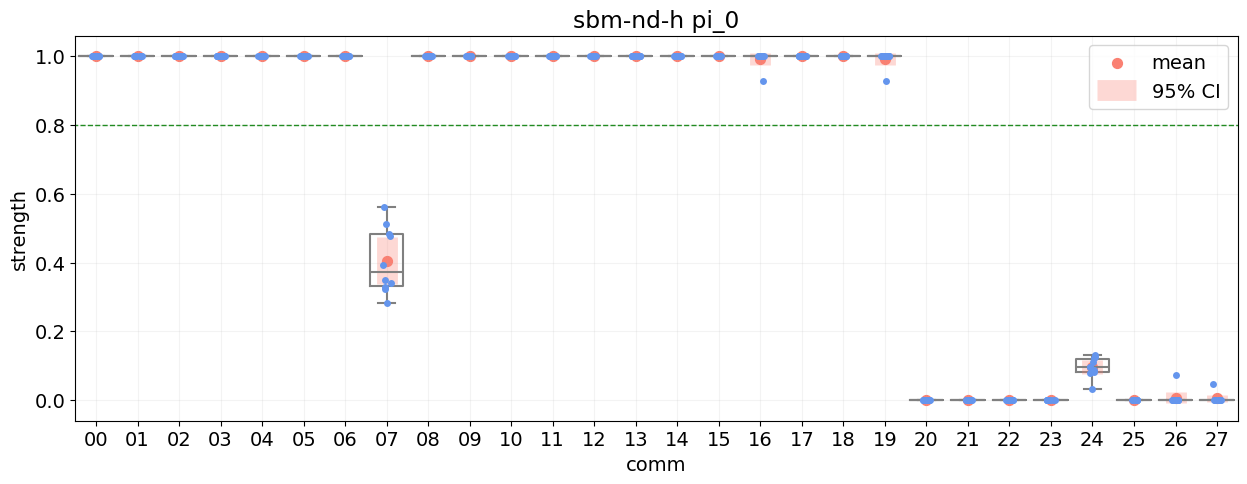

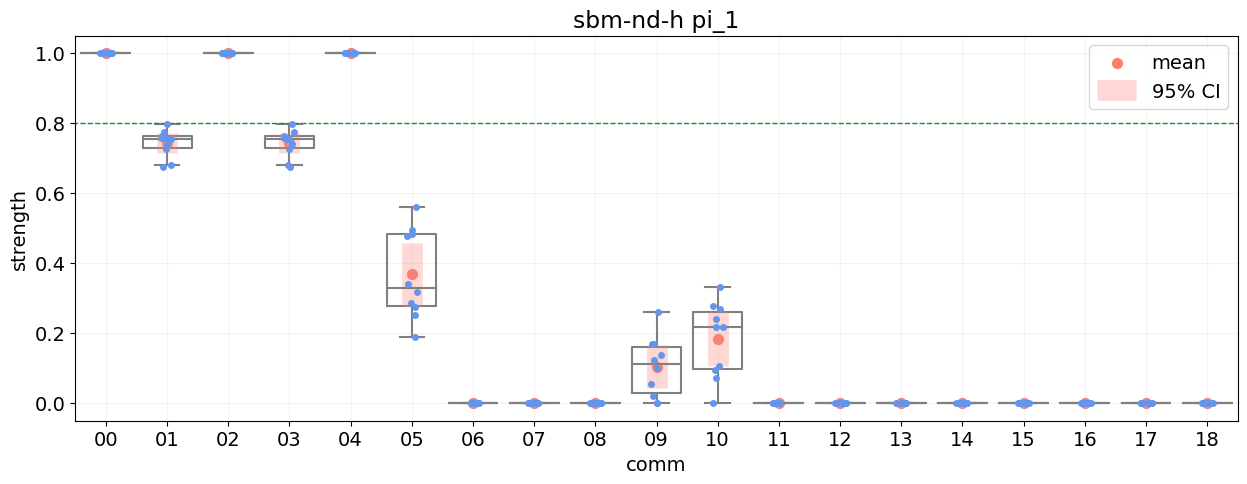

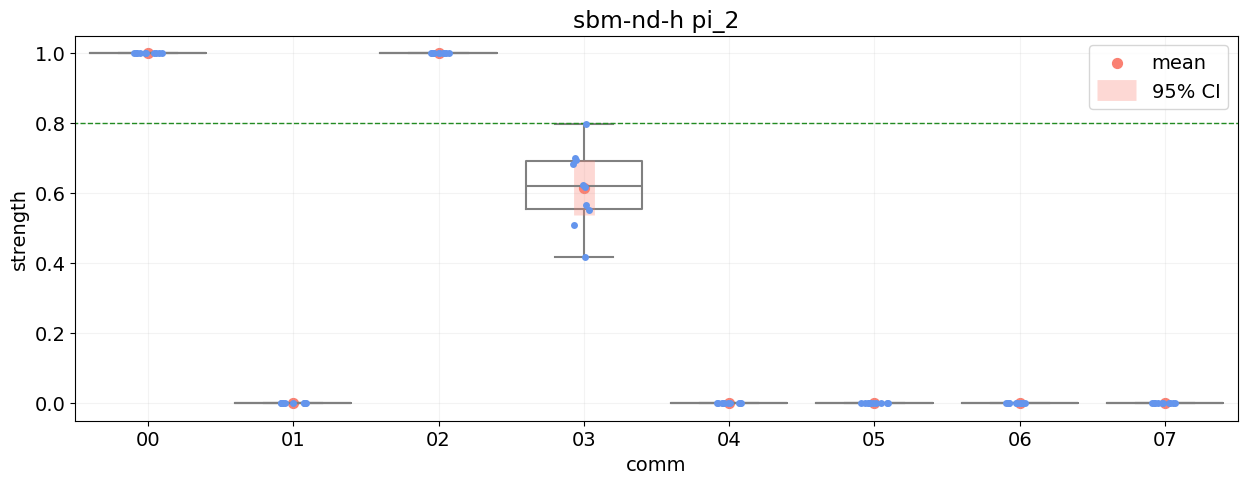

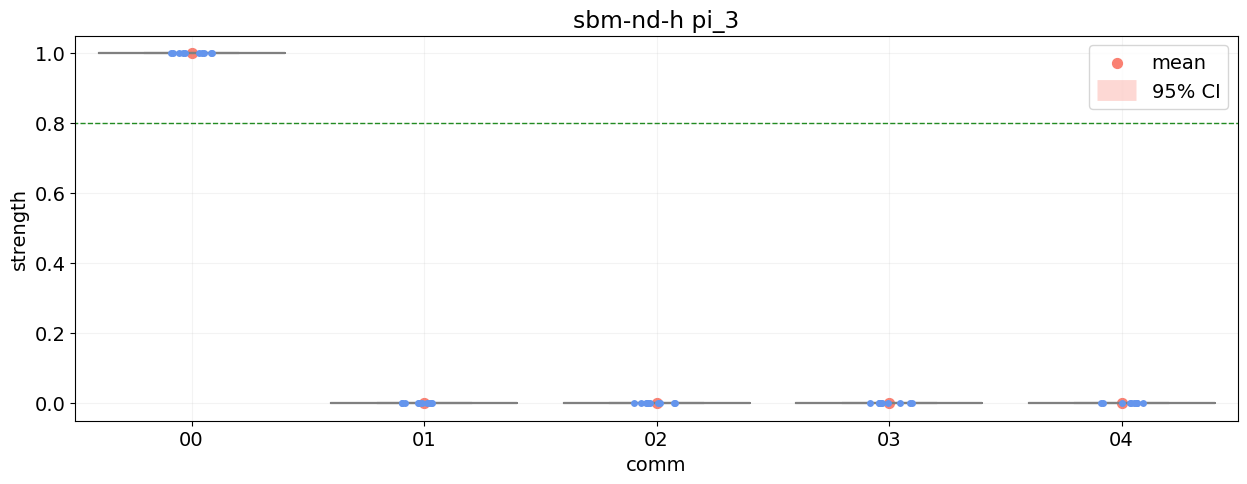

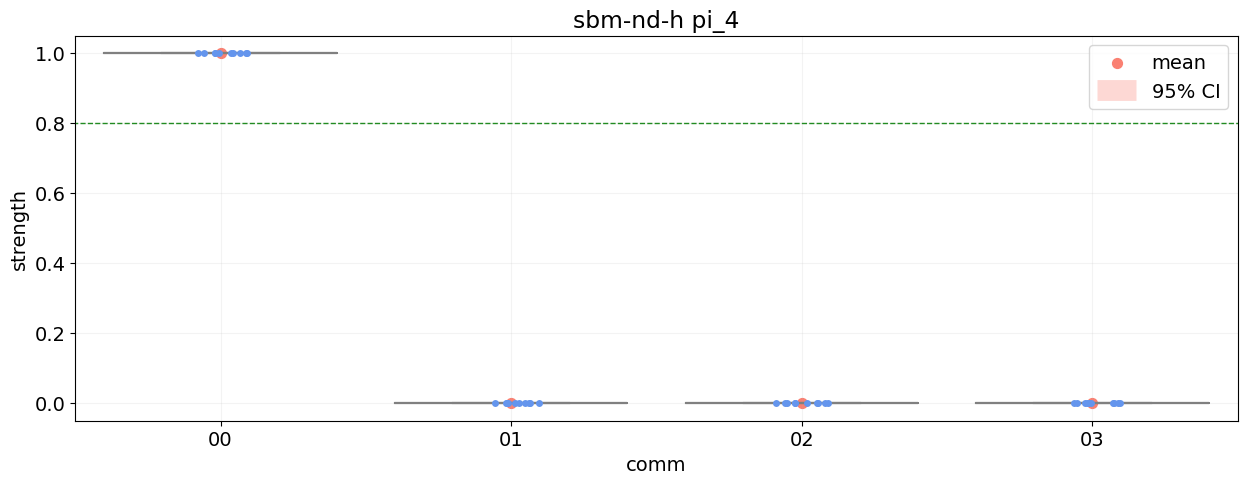

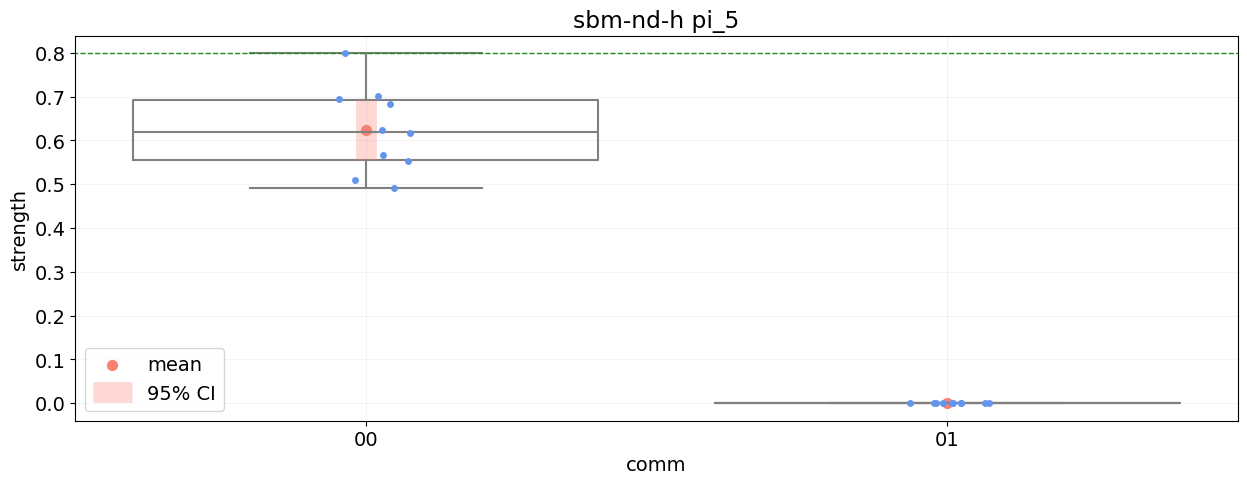

In [12]:
for col in cols:
    S = np.squeeze(get_membership_matrix(1, strengths_df, col))
    df = pd.DataFrame(
        S, 
        columns=[f'comm{i:02d}' for i in range(S.shape[-1])]
    ).melt(
        var_name='comm', 
        value_name='strength'
    )
    fig = plot_comm_strengths(S, df, col, cutoff=0.8)